In [2]:
import pygmsh
import meshio
import pygalmesh
import hoomd
import hoomd.md
import numpy as np
import copy
import optimesh
from mshr import *
from dolfin import *
from collections import Counter

# Make a basic mesh

## Dolfin

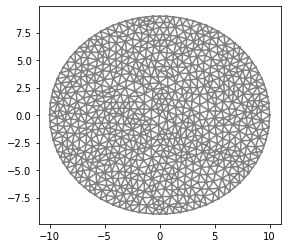

In [3]:
# make the mesh
#domain = Circle(Point(0, 0, 0), 10)
domain = Ellipse(Point(0, 0, 0),10.0,9.0, 50)
mesh = generate_mesh(domain, 20)
mesh.init()
plot(mesh)

In [4]:
# output using meshio

# need to add a 3rd dimension 0 coordinate here
points = np.insert(mesh.coordinates(),2,0,axis=1)
cells = cells = [("triangle",mesh.cells() )]
InputMesh = meshio.Mesh(points,cells)
InputMesh.write("Disk.vtk")

In [5]:
#copy for modifying at output
Outputmesh=copy.deepcopy(InputMesh)

In [6]:
# make list of:
#interior bonds : interiorbonds
# edge bonds :edgepoints
# bonds : interiorbonds+edgebonds
# angle triples: angletriples
mesh.cells()
triangles=mesh.cells()
x = [[[triangle[0],triangle[1]],[triangle[0],triangle[2]],[triangle[1],triangle[2]] ]   for triangle in triangles]
flattenedx = [val for sublist in x for val in sublist]
bonds = [[x[0],x[1]] if x[0]<x[1] else [x[1],x[0]] for x in flattenedx]

# get a list of the bonds on the edge, and in the interior
edgebonds=[]
interiorbonds=[]
for elem in bonds:
    if 1==bonds.count(elem):
        edgebonds.append(elem)
    elif 2==bonds.count(elem) and elem not in interiorbonds:
        interiorbonds.append(elem)

bonds=interiorbonds+edgebonds
        
# for the edge bonds, get the angle triples
EdgeVertices = list(set([val for sublist in edgebonds for val in sublist]))
angletriples=[]

for vertex in EdgeVertices:
    Neighbors=[x for x in edgebonds if vertex in x]
    NeighborVertices = [val for sublist in Neighbors for val in sublist if val!=vertex]
    angletriples.append([NeighborVertices[0],vertex,NeighborVertices[1]])
    
        

## pygmesh

In [ ]:
# https://github.com/nschloe/pygmsh/issues/262
#with pygmsh.geo.Geometry() as geom:
#    geom.add_circle([0,0],10,mesh_size=0.1)
#    mesh = geom.generate_mesh()

In [ ]:
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = 1
    geom.add_disk([0.0, 0.0], radius0=10.0,radius1=9.0,mesh_size=0.5),
    InputMesh = geom.generate_mesh()

In [ ]:
InputMesh.write("Disk.vtk")

In [ ]:
Outputmesh=copy.deepcopy(InputMesh)

In [ ]:
# make list of:
#interior bonds : interiorbonds
#edge bonds :edgepoints
# angle triples: angletriples

triangles=InputMesh.cells[1].data
x = [[[triangle[0],triangle[1]],[triangle[0],triangle[2]],[triangle[1],triangle[2]] ]   for triangle in triangles]
flattenedx = [val for sublist in x for val in sublist]
orderedx = [[x[0],x[1]] if x[0]<x[1] else [x[1],x[0]] for x in flattenedx]
bonds = []

bonds = []
for elem in orderedx:
    if elem not in bonds:
        bonds.append(elem)

# sort the edge bonds
edgebonds = [[x[0],x[1]] if x[0]<x[1] else [x[1],x[0]] for x in InputMesh.cells[0].data]
interiorbonds=[x for x in bonds if x not in edgebonds]

# hacky angle triples
NEdgeBonds= len(edgebonds)
angletriples=[[(i-1)%NEdgeBonds,i,(i+1)%NEdgeBonds] for i in range(0,NEdgeBonds) ]

bonds=interiorbonds+edgebonds

 # Initialising the HOOMD simulation 

When we get here, I demand 

In [7]:
hoomd.context.initialize("");

HOOMD-blue 2.9.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 06/26/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


Define the snapshot. We will have a unique bond id for every bond in the system, as they will all have different rest lengths. We also want to make a distinction between surface and bulk bonds.

In [8]:
# number of points and bonds
Npts=len(InputMesh.points);
NBonds = len(bonds);
#indices
bondindices = list(range(0,NBonds))
#surface bond or not
bondclassification = [0]*len(interiorbonds)+[1]*len(edgebonds)

In [9]:
snapshot = hoomd.data.make_snapshot(N=Npts
                                    ,box=hoomd.data.boxdim(Lx=200, Ly=200,dimensions=2)
                                    ,particle_types=['A']
                                    ,bond_types=[str(i) for i in  bondindices]
                                    ,angle_types=['0']
                                   );

Read in the points, bonds and angles

In [10]:
# points
snapshot.particles.position[:] = InputMesh.points;
snapshot.particles.typeid[0:Npts]=0
# bonds
snapshot.bonds.resize(NBonds)
snapshot.bonds.group[:] = bonds
snapshot.bonds.typeid[:] = bondindices
#angle triples
snapshot.angles.resize(len(angletriples))
snapshot.angles.group[:] = angletriples
snapshot.angles.typeid[:len(angletriples)] =0

In [11]:
system=hoomd.init.read_snapshot(snapshot);

notice(2): Group "all" created containing 811 particles


Right, lets define the bond type and parameters for each bond

In [12]:
harmonic = hoomd.md.bond.harmonic();

for i in snapshot.bonds.typeid:
    p1,p2 = snapshot.bonds.group[i]
    
    if(0==bondclassification[i]):  
        restlength=np.linalg.norm(InputMesh.points[p2] - InputMesh.points[p1])
        harmonic.bond_coeff.set(str(i), k=1, r0=restlength);

    if(1==bondclassification[i]): 
        restlength=np.linalg.norm(InputMesh.points[p2] - InputMesh.points[p1])
        harmonic.bond_coeff.set(str(i), k=1, r0=40*restlength);

angle = hoomd.md.angle.harmonic();
angle.angle_coeff.set('0', k=400, t0=np.pi-0*((2*np.pi)/len(edgebonds)) );

Define the integrator. In this case, a langevin dynamics

In [13]:
hoomd.md.integrate.mode_standard(dt=0.01);
all = hoomd.group.all();
integrator = hoomd.md.integrate.langevin(group=all,kT=0,seed=0,dscale=2);

notice(2): integrate.langevin/bd is determining gamma from particle diameters


Define a callback, which we want run periodically

In [14]:
class WritePositions:
    def __init__(self, system):
        self.system = system;
    def __call__(self, timestep):
        snap = self.system.take_snapshot();
        Outputmesh.points = snap.particles.position
        Outputmesh.write("Data/Run2/"+str(timestep)+".vtk")
        
hoomd.analyze.callback(callback=WritePositions(system), period=500);

# Run the simulation

In [15]:
hoomd.run(100000);

** starting run **
Time 00:00:13 | Step 69209 / 100000 | TPS 6920.85 | ETA 00:00:04
Time 00:00:17 | Step 100000 / 100000 | TPS 6945.43 | ETA 00:00:00
Average TPS: 6928.13
---------
** run complete **
